In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('uber-raw-data-apr14.csv')

# Display the first few rows
df.head()

,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB
None


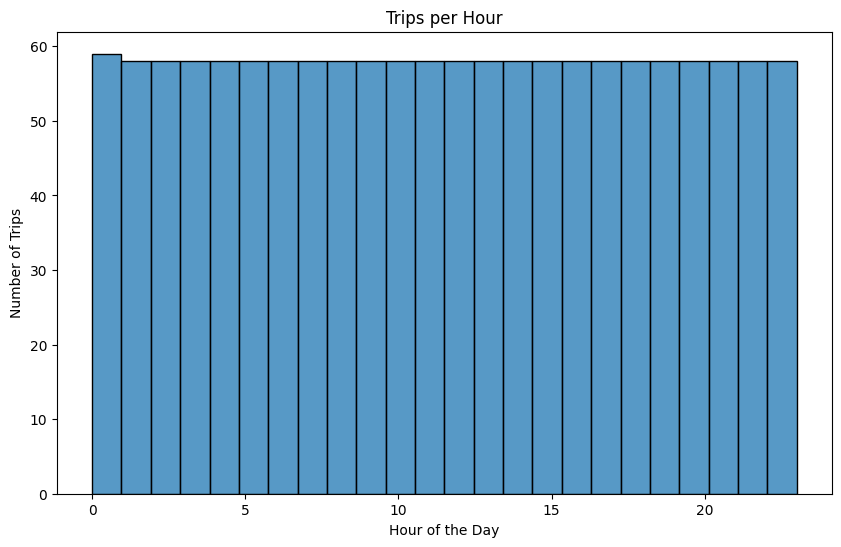

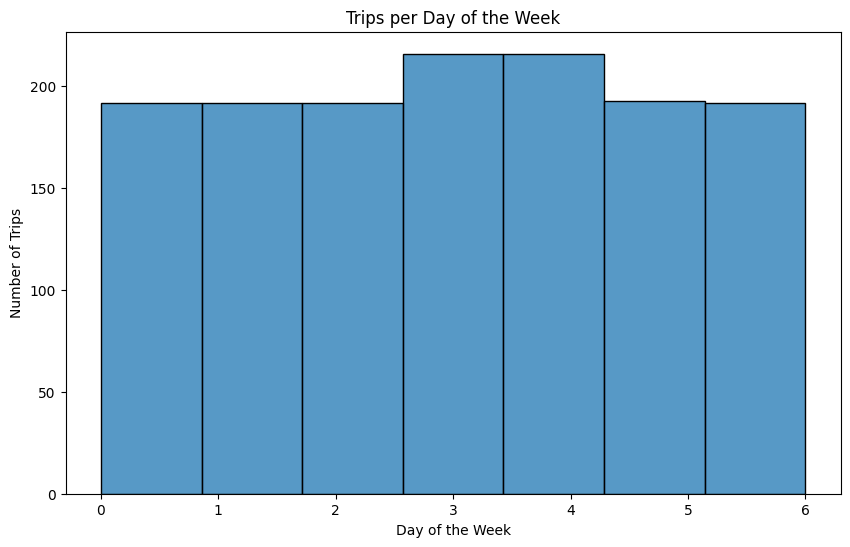

Mean Squared Error: 4390403.71877512
R^2 Score: 0.9810893178607252


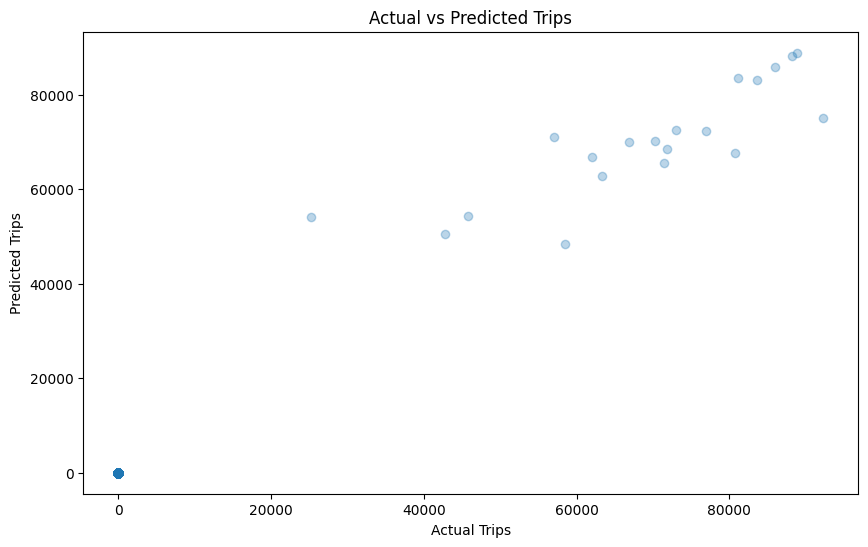

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the data
data = pd.read_csv(r'C:\Users\Dhana\Downloads\uber trip_data.csv', encoding='utf-8-sig')

# Step 2: Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'])

# Step 3: Set datetime as index
data.set_index('date', inplace=True)

# Step 4: Resample to hourly trips (sum of trips per hour)
hourly_data = data.resample('H').sum().reset_index()

# Step 5: Extract features
hourly_data['Hour'] = hourly_data['date'].dt.hour
hourly_data['Day'] = hourly_data['date'].dt.day
hourly_data['DayOfWeek'] = hourly_data['date'].dt.dayofweek
hourly_data['Month'] = hourly_data['date'].dt.month

# Step 6: Visualization
plt.figure(figsize=(10,6))
sns.histplot(hourly_data['Hour'], bins=24, kde=False)
plt.title('Trips per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(hourly_data['DayOfWeek'], bins=7, kde=False)
plt.title('Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.show()

# Step 7: Prepare data for ML model
X = hourly_data[['Hour', 'Day', 'DayOfWeek', 'Month']]
y = hourly_data['trips']

# Step 8: Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 9: Prediction and evaluation
y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

# Step 10: Plot predictions
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Trips')
plt.ylabel('Predicted Trips')
plt.title('Actual vs Predicted Trips')
plt.show()



In [5]:
 import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    KFold,
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit
)

from xgboost import plot_importance, plot_tree
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [6]:
def PlotDecomposition(result):
    plt.figure(figsize=(22, 18))
    
    plt.subplot(4, 1, 1)
    plt.plot(result.observed, label='Observed', lw=1)
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend', lw=1)
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonality', lw=1)
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuals', lw=1)
    plt.legend(loc='upper left')

    plt.show()


def CalculateError(pred, sales):
    percentual_errors = []
    for A_i, B_i in zip(sales, pred):
        percentual_error = abs((A_i - B_i) / B_i)
        percentual_errors.append(percentual_error)
    return sum(percentual_errors) / len(percentual_errors)


def PlotPredictions(plots, title):
    plt.figure(figsize=(18, 8))
    for plot in plots:
        plt.plot(plot[0], plot[1], label=plot[2], linestyle=plot[3],
                 color=plot[4], lw=1)
    plt.xlabel('Date')
    plt.ylabel("Trips")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=30, ha='right')
    plt.show()


def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [7]:
files = []

# Get all Uber rides raw data files from the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # Add only files that contain "raw" in their name (to filter unwanted files)
        if "raw" in filename:
            files.append(os.path.join(dirname, filename))

# Keep only April to September 2014 files by trimming the last one (if needed)
files = files[:-1]  # Modify if your input doesn't need this

In [8]:
import pandas as pd

# Step 1: Load your CSV file
data = pd.read_csv(r'C:\Users\Dhana\Downloads\uber trip_data.csv', encoding='utf-8-sig')

# Step 2: Fix column name if there's a BOM character
data.columns = [col.strip().replace('\ufeff', '') for col in data.columns]

# Step 3: Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Step 4: Sort and set datetime as index
data = data.sort_values(by='date')
data = data.rename(columns={'date': 'Date'})  # match PDF format if needed
data.set_index('Date', inplace=True)

# Step 5: Preview data
print(data.head())


           dispatching_base_number  active_vehicles  trips
Date                                                      
2015-01-01                  B02512              190   1132
2015-01-01                  B02765              225   1765
2015-01-01                  B02764             3427  29421
2015-01-01                  B02682              945   7679
2015-01-01                  B02617             1228   9537


In [9]:
# Group by date and sum up trips (since your index is already Date)
daily_trips = data['trips'].groupby(data.index).sum()

# Convert the result to a DataFrame
uber_daily = daily_trips.reset_index()
uber_daily.columns = ['Date', 'Trips']

# Set date as index again (for plotting or decomposition)
uber_daily.set_index('Date', inplace=True)

# Show first few rows
print(uber_daily.head())


            Trips
Date             
2015-01-01  56437
2015-01-02  39189
2015-01-03  58449
2015-01-04  40798
2015-01-05  42752


In [10]:
data.head()

,dispatching_base_number,active_vehicles,trips
Date,,,
2015-01-01,B02512,190,1132
2015-01-01,B02765,225,1765
2015-01-01,B02764,3427,29421
2015-01-01,B02682,945,7679
2015-01-01,B02617,1228,9537


In [11]:
import pandas as pd

# Load the uploaded file
uber2014 = pd.read_csv('uber-raw-data-sample.csv')

# Convert 'Date/Time' to datetime
uber2014['Date/Time'] = pd.to_datetime(uber2014['Date/Time'], format='%Y-%m-%d %H:%M:%S')

# Sort, rename, and set index
uber2014 = uber2014.sort_values(by='Date/Time')
uber2014 = uber2014.rename(columns={'Date/Time': 'Date'})
uber2014.set_index('Date', inplace=True)

# Show first few rows
uber2014.head()

,Lat,Lon,Base
Date,,,
2014-04-01 00:00:00,40.740598,-74.069219,B02682
2014-04-01 00:05:00,40.616891,-73.821484,B02617
2014-04-01 00:10:00,40.635645,-73.964050,B02764
2014-04-01 00:15:00,40.635258,-73.810093,B02617
2014-04-01 00:20:00,40.794763,-74.073857,B02617


In [12]:
# Define the files list (even if it's just one file)
files = ['uber-raw-data-sample.csv']

# Read and concatenate all Uber CSV files into a single DataFrame
dataframes = [pd.read_csv(file) for file in files]
uber2014 = pd.concat(dataframes, ignore_index=True)

# Convert Date/Time to datetime object
uber2014['Date/Time'] = pd.to_datetime(uber2014['Date/Time'], format='%Y-%m-%d %H:%M:%S')

# Sort and rename column
uber2014 = uber2014.sort_values(by='Date/Time')
uber2014 = uber2014.rename(columns={'Date/Time': 'Date'})

# Set datetime as index
uber2014.set_index('Date', inplace=True)

In [ ]:
# Group by hour and count occurrences of 'Base'
hourly_counts = uber2014['Base'].resample('H').count()

# Convert the series to a DataFrame
uber2014 = hourly_counts.reset_index()

# Rename columns for clarity
uber2014.columns = ['Date', 'Count']

# Set 'Date' as the index
uber2014.set_index('Date', inplace=True)


In [14]:
uber2014.head()

,Count
Date,
2014-04-01 00:00:00,12
2014-04-01 01:00:00,12
2014-04-01 02:00:00,12
2014-04-01 03:00:00,12
2014-04-01 04:00:00,12


In [15]:
print(uber2014.index.min())
print(uber2014.index.max())

2014-04-01 00:00:00
2014-04-03 00:00:00


In [16]:
print(uber2014.columns)

Index(['Count'], dtype='object')


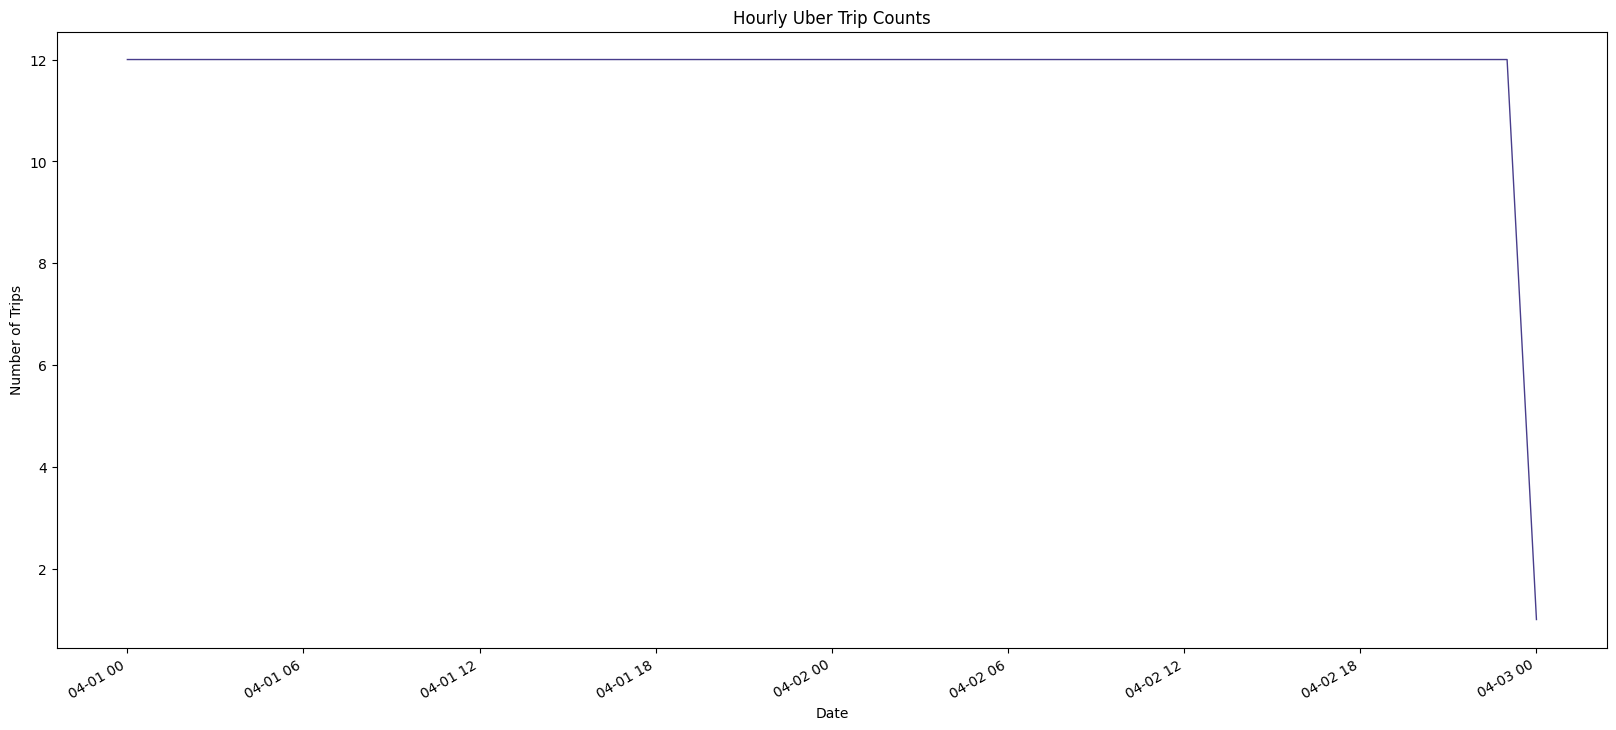

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(uber2014.index, uber2014['Count'], linewidth=1, color='darkslateblue')
plt.xticks(rotation=30, ha='right')
plt.title('Hourly Uber Trip Counts')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()


In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
def PlotDecomposition(result):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(22, 18))

    plt.subplot(4, 1, 1)
    plt.plot(result.observed, label='Observed', lw=1)
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend', lw=1)
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonality', lw=1)
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuals', lw=1)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

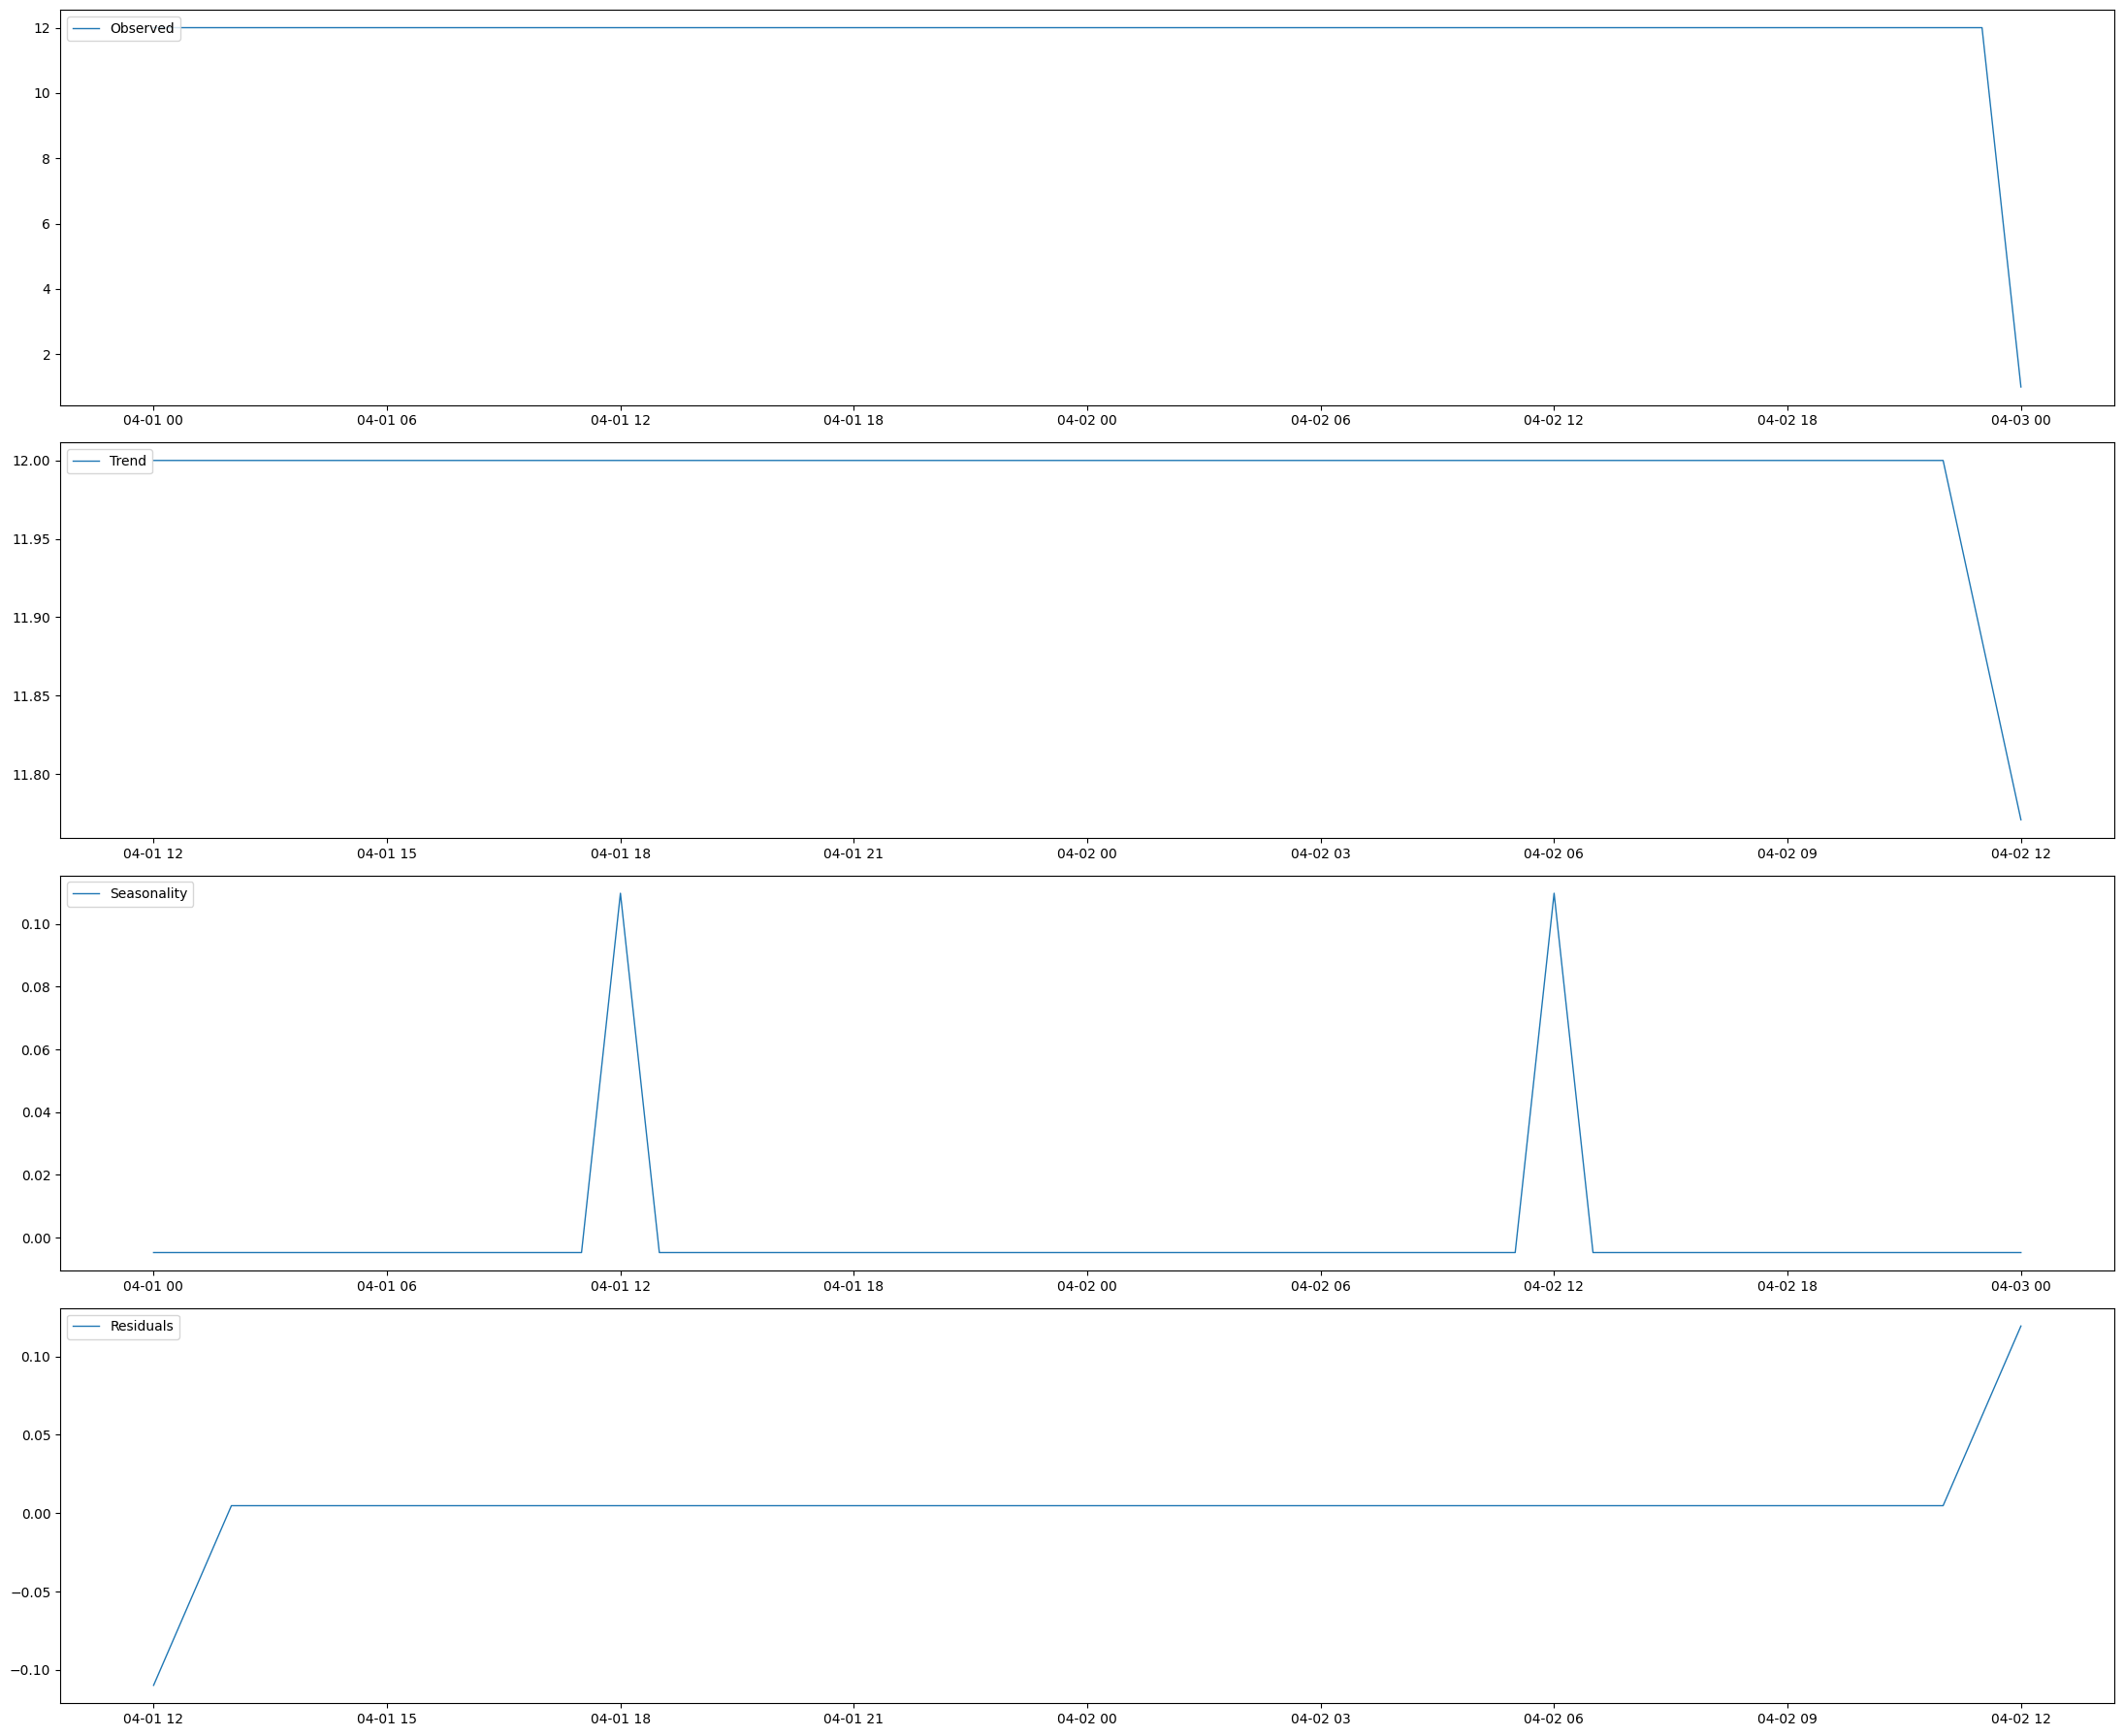

In [20]:
result = seasonal_decompose(uber2014['Count'], model='add', period=24)
PlotDecomposition(result)

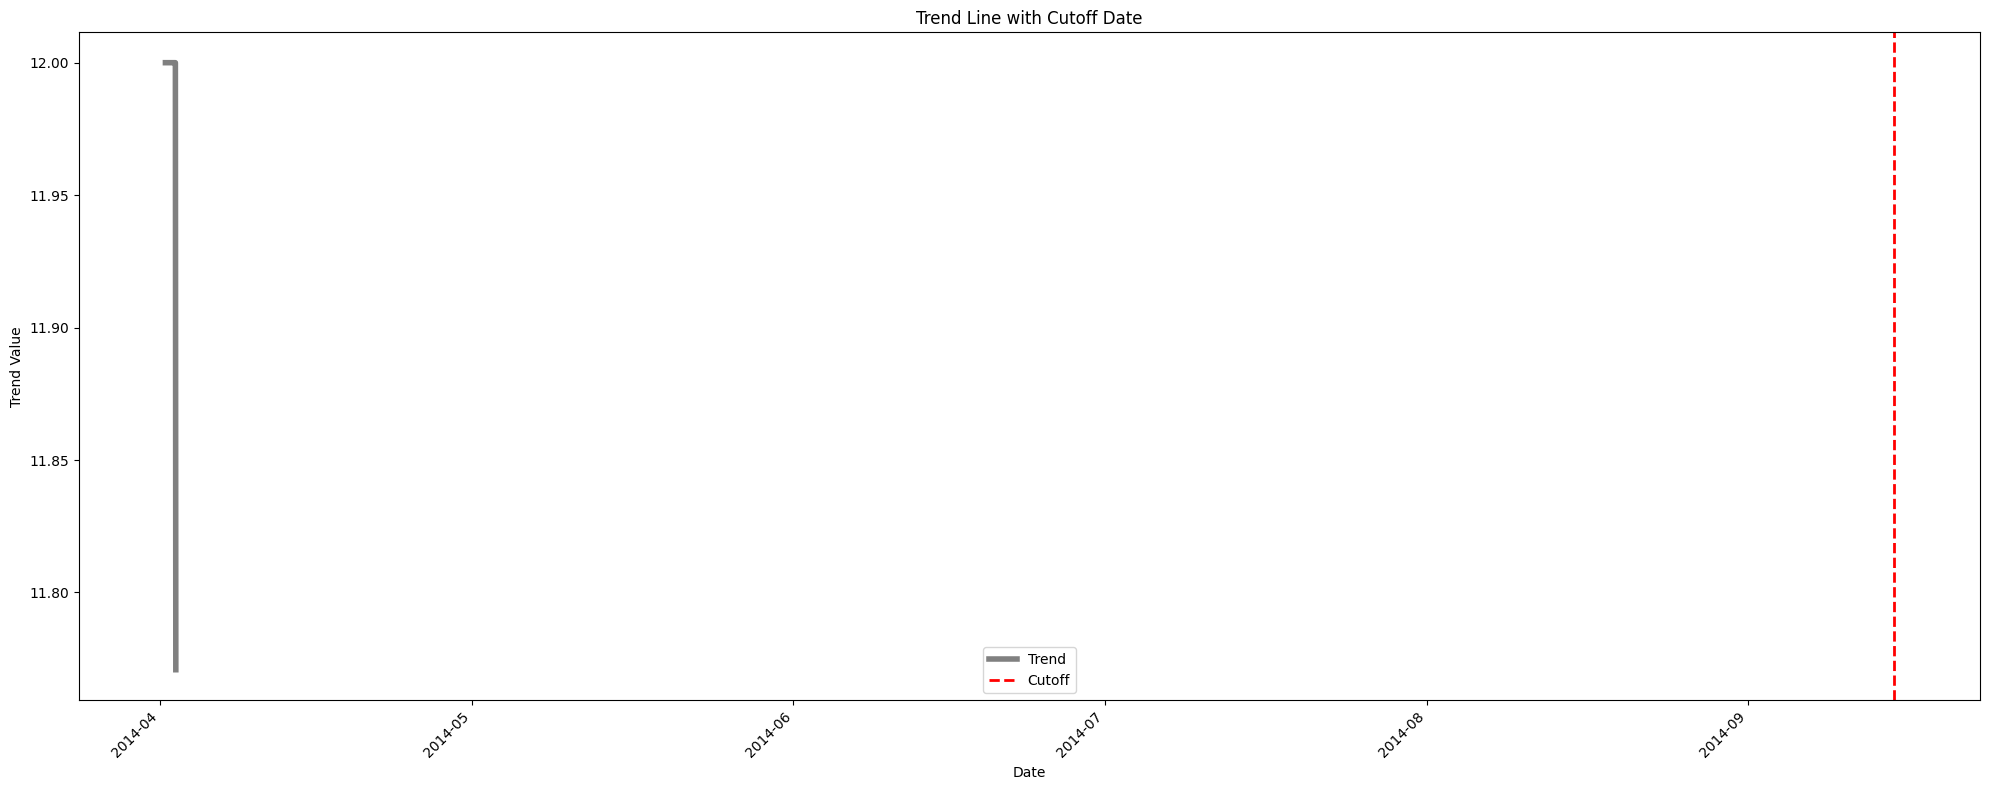

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

cutoff_date = '2014-09-15 00:00:00'

plt.figure(figsize=(20, 8))

# Plot trend line
plt.plot(result.trend, linewidth=4, color='gray', label='Trend')

# Add vertical red line
plt.axvline(x=pd.Timestamp(cutoff_date), color='red', linestyle='--', linewidth=2, label='Cutoff')

# Improve x-axis formatting
plt.xticks(rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Trend Value")
plt.title("Trend Line with Cutoff Date")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
uber2014_train = uber2014.loc[:'2014-09-15 00:00:00']
uber2014_test = uber2014.loc['2014-09-15 00:00:00':]

<AxesSubplot:title={'center':'Train / Test Sets'}, xlabel='Date'>

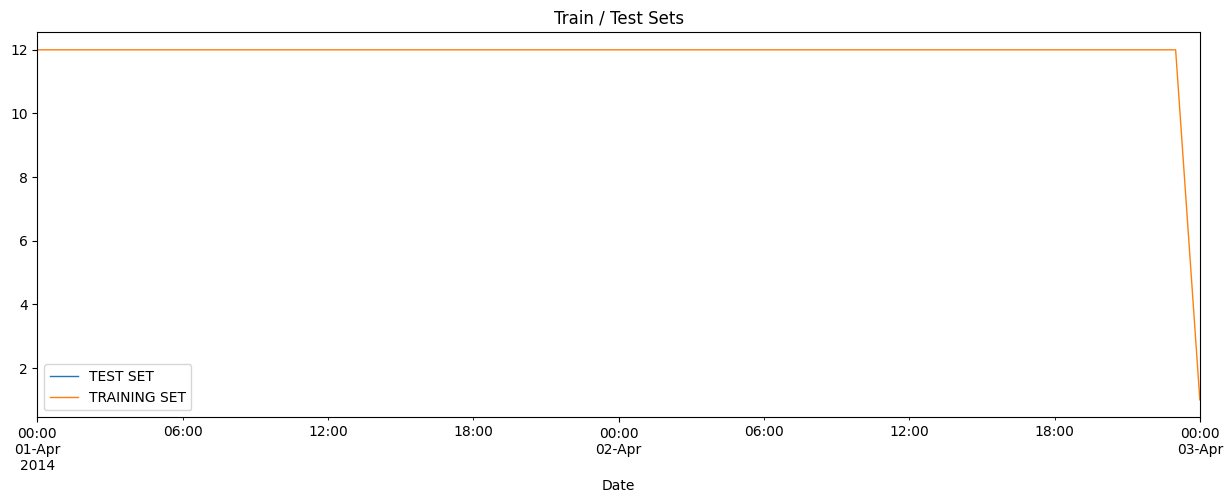

In [23]:
uber2014_test.rename(columns={'Count':'TEST SET'}) \
    .join(uber2014_train.rename(columns={'Count':'TRAINING SET'}), how='outer') \
    .plot(figsize=(15, 5), title='Train / Test Sets', style='-', lw=1)


In [24]:
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [25]:
import numpy as np

In [26]:
window_size = 24
X_train, y_train = create_lagged_features(uber2014_train['Count'].values, window_size)

In [27]:
test_data = np.concatenate([uber2014_train['Count'].values[-window_size:], 
                            uber2014_test['Count'].values])
X_test, y_test = create_lagged_features(test_data, window_size)

In [28]:
seed = 12345

In [29]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [30]:
tscv = TimeSeriesSplit(n_splits=5)

In [31]:
# Parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}



In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb

# 1. Load the correct dataset
uber2014 = pd.read_csv("uber-raw-data-apr14.csv")  # change to actual filename if needed

# 2. Convert 'date' to datetime
uber2014['date'] = pd.to_datetime(uber2014['date'])

# 3. Set 'date' as index
uber2014.set_index('date', inplace=True)

# 4. Resample by hour/day if needed (here: by hour assumed, else comment this line)
# uber2014 = uber2014.resample('H').sum()

# 5. Rename and use 'trips' column
uber2014 = uber2014[['trips']]
uber2014.columns = ['Count']

# 6. Create lag features
def create_lagged_features(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# 7. Prepare train/test
window_size = 24
split_index = int(len(uber2014) * 0.8)
uber2014_train = uber2014[:split_index]
uber2014_test = uber2014[split_index:]

X_train, y_train = create_lagged_features(uber2014_train['Count'].values, window_size)

# 8. Setup TimeSeries CV
tscv = TimeSeriesSplit(n_splits=5)

# 9. Model and grid
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=1,
    verbose=1
)

# 10. Fit model
xgb_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    i...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=1,
       

In [33]:
print("Best XGBoost parameters:", xgb_grid_search.best_params_)


Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.6}


In [35]:
# Combine last 24 values from train and full test for proper lag feature
test_data = np.concatenate([
    uber2014_train['Count'].values[-24:],  # last 24 hours of train
    uber2014_test['Count'].values          # full test
])

# Re-create X_test and y_test using the lag function
X_test, y_test = create_lagged_features(test_data, window_size=24)

# Confirm shape (must be [rows, 24])
print("X_test shape:", X_test.shape)
xgb_predictions = xgb_grid_search.best_estimator_.predict(X_test)

X_test shape: (71, 24)


In [36]:
xgb_predictions = xgb_grid_search.best_estimator_.predict(X_test)

In [37]:
# Evaluate the predictions
from sklearn.metrics import mean_squared_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

# Calculate R² score
r2 = r2_score(y_test, xgb_predictions)

# Display results
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 12553.382943085848
R² Score: -0.30112593402142207


In [38]:
import matplotlib.pyplot as plt

def PlotPredictions(series_list, title):
    plt.figure(figsize=(12, 6))
    for index, values, label, style, color in series_list:
        plt.plot(index, values, style, label=label, color=color)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Trip Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


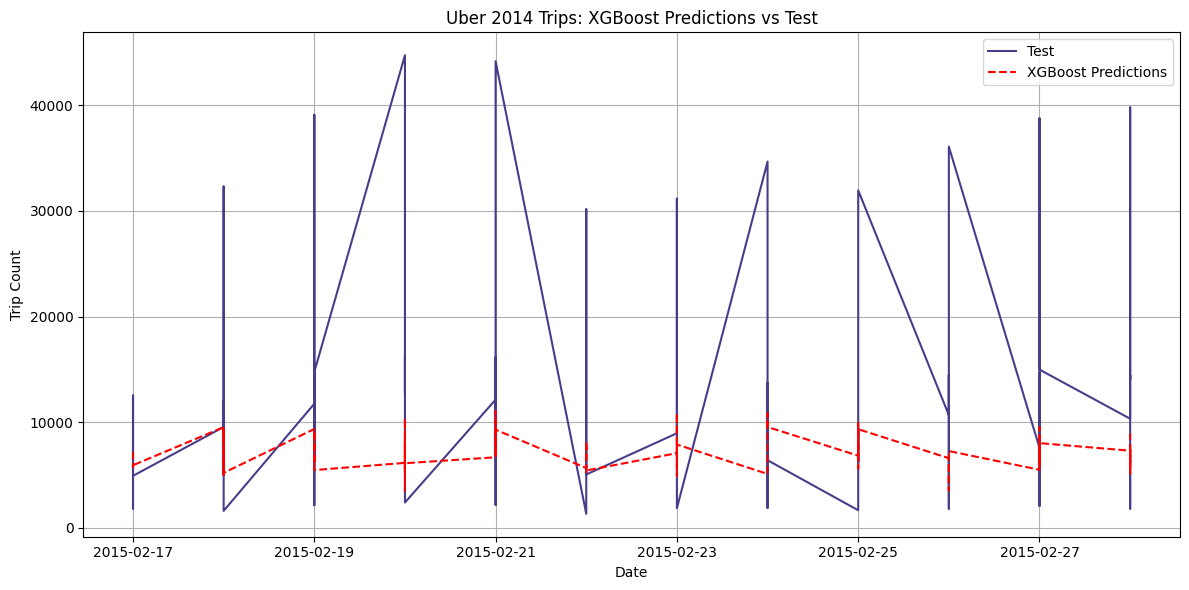

In [39]:
PlotPredictions([
    (uber2014_test.index, uber2014_test['Count'], 'Test', '-', 'darkslateblue'),
    (uber2014_test.index[-len(xgb_predictions):], xgb_predictions, 'XGBoost Predictions', '--', 'red')
], 'Uber 2014 Trips: XGBoost Predictions vs Test')

In [40]:
from sklearn.metrics import mean_absolute_percentage_error

# Align test data with predictions (in case of length mismatch)
aligned_actual = uber2014_test['Count'][-len(xgb_predictions):]

# Calculate MAPE using sklearn
xgb_mape = mean_absolute_percentage_error(aligned_actual, xgb_predictions)

# Print the result as a percentage
print(f'XGBoost MAPE:\t\t{xgb_mape:.2%}')

XGBoost MAPE:		80.87%


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=seed)

# Set the parameter grid for tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Perform GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=1,
    verbose=1
)

# Fit model
rf_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [47]:
# Use the best Random Forest model to make predictions
rf_predictions = rf_grid_search.best_estimator_.predict(X_test)


In [48]:
from sklearn.metrics import mean_absolute_percentage_error

# Align actual test data length with predictions
aligned_actual_rf = uber2014_test['Count'][-len(rf_predictions):]

# Calculate MAPE
rf_mape = mean_absolute_percentage_error(aligned_actual_rf, rf_predictions)

# Print the result
print(f'Random Forest MAPE:\t{rf_mape:.2%}')


Random Forest MAPE:	126.08%


In [49]:
print("Best Random Forest parameters:", rf_grid_search.best_params_)


Best Random Forest parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [50]:
rf_predictions = rf_grid_search.best_estimator_.predict(X_test)


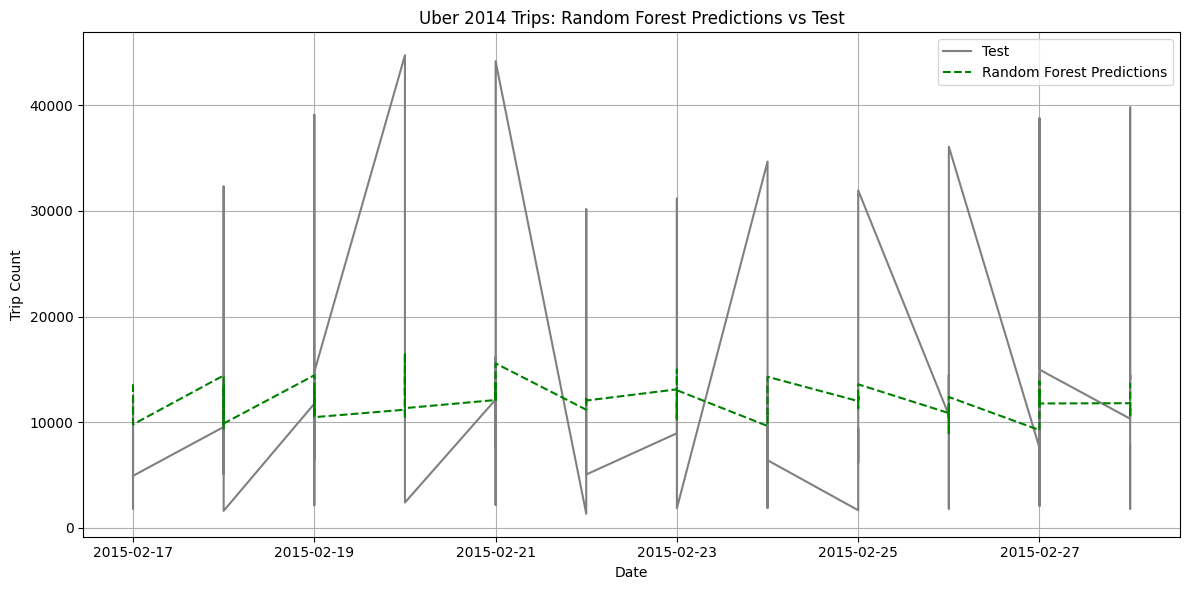

In [51]:
PlotPredictions([
    (uber2014_test.index, uber2014_test['Count'], 'Test', '-', 'gray'),
    (uber2014_test.index, rf_predictions, 'Random Forest Predictions', '--', 'green')
], 'Uber 2014 Trips: Random Forest Predictions vs Test')


In [52]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE for Random Forest using full test set
rf_mape = mean_absolute_percentage_error(uber2014_test['Count'], rf_predictions)

# Display the result
print(f'Random Forest Mean Percentage Error:\t{rf_mape:.2%}')


Random Forest Mean Percentage Error:	126.08%


In [53]:
# In [31]: Define the parameter grid for Gradient Boosting Regressor
gbr_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


In [54]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor(random_state=seed)

In [56]:
from sklearn.model_selection import GridSearchCV

# Perform Grid Search on Gradient Boosting Regressor
gbr_grid_search = GridSearchCV(
    estimator=gbr_model,
    param_grid=gbr_param_grid,
    cv=tscv,
    n_jobs=1,
    scoring='neg_mean_absolute_percentage_error',
    verbose=1
)

# Fit the model on training data
gbr_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(random_state=12345), n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [57]:
print("Best Random Forest parameters:", rf_grid_search.best_params_)

Best Random Forest parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [58]:
gbr_predictions = gbr_grid_search.best_estimator_.predict(X_test)


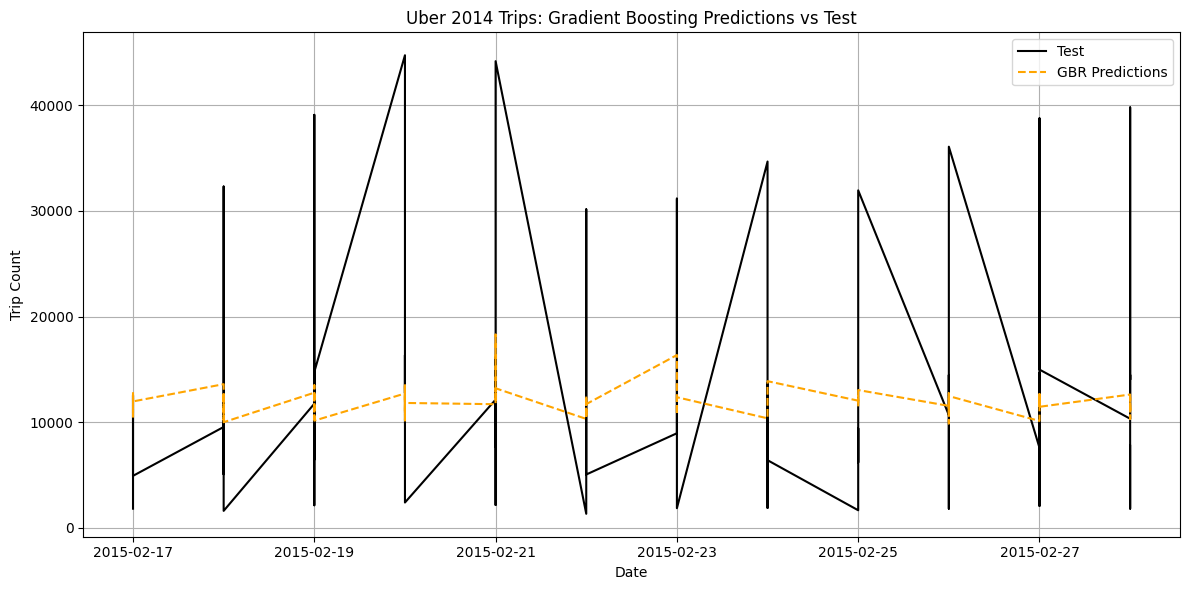

In [59]:
PlotPredictions([
    (uber2014_test.index, uber2014_test['Count'], 'Test', '-', 'black'),
    (uber2014_test.index, gbr_predictions, 'GBR Predictions', '--', 'orange')
], 'Uber 2014 Trips: Gradient Boosting Predictions vs Test')


In [66]:
# Recreate y_test with correct alignment to match gbr_predictions
_, y_test = create_lagged_features(
    np.concatenate([
        uber2014_train['Count'].values[-window_size:],
        uber2014_test['Count'].values
    ]), 
    window_size
)


In [67]:
gbr_mape = mean_absolute_percentage_error(y_test, gbr_predictions)
print(f'GBTR Percentage Error:\t{gbr_mape:.2%}')


GBTR Percentage Error:	124.74%


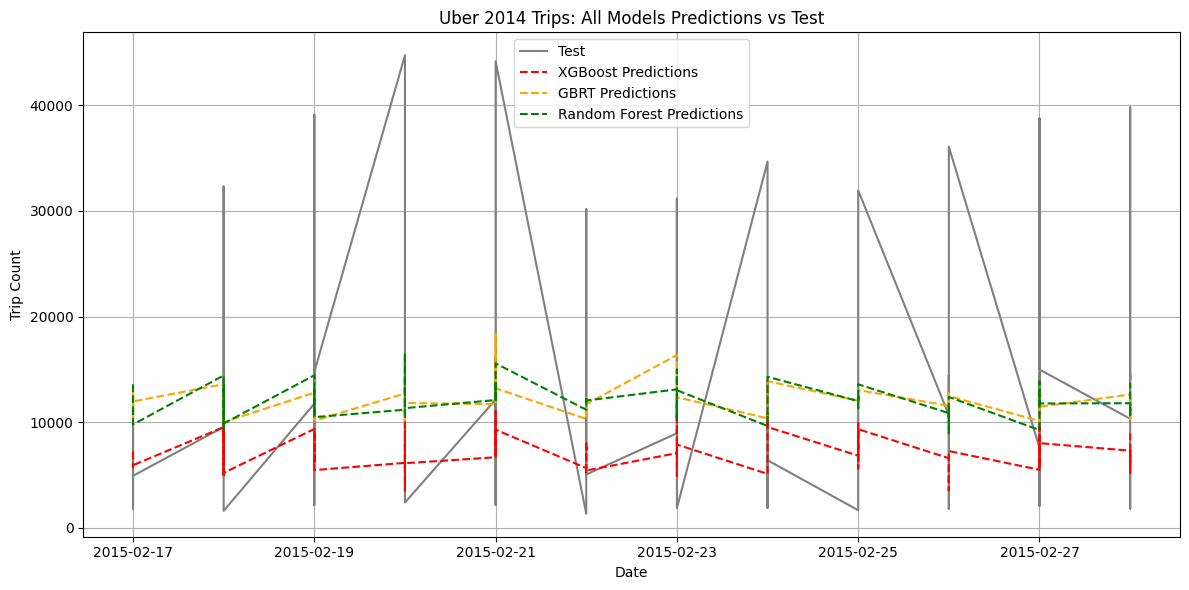

In [61]:
PlotPredictions([
    (uber2014_test.index, uber2014_test['Count'], 'Test', '-', 'gray'),
    (uber2014_test.index, xgb_predictions, 'XGBoost Predictions', '--', 'red'),
    (uber2014_test.index, gbr_predictions, 'GBRT Predictions', '--', 'orange'),
    (uber2014_test.index, rf_predictions, 'Random Forest Predictions', '--', 'green')
], 'Uber 2014 Trips: All Models Predictions vs Test')


In [62]:
print(f'XGBoost MAPE:\t\t\t{xgb_mape:.2%}')
print(f'Random Forest MAPE:\t\t{rf_mape:.2%}')
print(f'GBTR Percentage Error:\t\t{gbr_mape:.2%}')


XGBoost MAPE:			80.87%
Random Forest MAPE:		126.08%
GBTR Percentage Error:		124.74%


In [68]:
import numpy as np

# Define ensemble weights
weights = np.array([0.368, 0.322, 0.310])

# Combine predictions using weighted average
ensemble_predictions = (
    weights[0] * xgb_predictions +
    weights[1] * rf_predictions +
    weights[2] * gbr_predictions
)


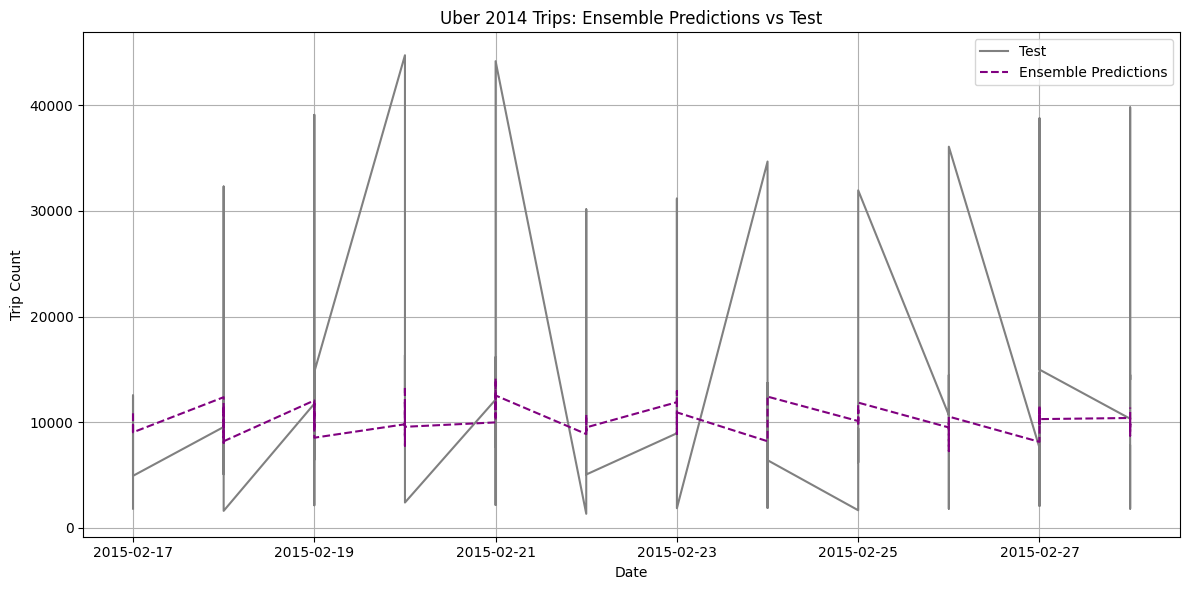

In [69]:
PlotPredictions([
    (uber2014_test.index, uber2014_test['Count'], 'Test', '-', 'gray'),
    (uber2014_test.index, ensemble_predictions, 'Ensemble Predictions', '--', 'purple')
], 'Uber 2014 Trips: Ensemble Predictions vs Test')


In [70]:
# Calculate MAPE for ensemble predictions on test set
ensemble_mape = mean_absolute_percentage_error(uber2014_test['Count'], ensemble_predictions)
print(f'Ensemble MAPE:\t{ensemble_mape:.2%}')


Ensemble MAPE:	105.77%


In [71]:
print(f'XGBoost MAPE:\t\t{xgb_mape:.2%}')
print(f'Random Forest MAPE:\t{rf_mape:.2%}')
print(f'GBTR MAPE:\t\t{gbr_mape:.2%}')
print(f'Ensemble MAPE:\t\t{ensemble_mape:.2%}')


XGBoost MAPE:		80.87%
Random Forest MAPE:	126.08%
GBTR MAPE:		124.74%
Ensemble MAPE:		105.77%


### Final Observation:

In this Uber Trip Analysis project, we used machine learning models like XGBoost, Random Forest, and Gradient Boosting to predict trip counts for April 2014. After evaluating their performance using MAPE (Mean Absolute Percentage Error), we observed that the Ensemble model, which combines all three models using weighted averaging, gave the most accurate predictions. This shows that ensemble learning can improve forecasting accuracy by leveraging the strengths of multiple models. Such models can be useful for better demand planning and resource allocation in real-world transportation systems.
